# Final Project - Natural Language Processing- 2022
## Topic: Summarization of Messenger-Like Conversations

### Dataset
   * [SAMsum](https://huggingface.co/datasets/samsum): contains about 16k messenger-like conversations with summaries.The style and register are diversified - conversations could be informal, semi-formal or formal, they may contain slang words, emoticons and typos. Then, the conversations were annotated with summaries. It was assumed that summaries should be a concise brief of what people talked about in the conversation in third person. The SAMSum dataset was prepared by Samsung R&D Institute Poland and is distributed for research purposes (non-commercial licence: CC BY-NC-ND 4.0).
   * Language: English
   
### Tasks
In this notebook we will:
   * Analize the SAMsum dataset
   * Build a data preprosses pipeline
   * Build a baseline model
   * Fine tune 3 popular pre-trained language models
   * Evaluate the results


### Metrics:
We will keep track of the
   * Rouge1
   * Rouge2
   * Rougel
   * Rougelsum

metrics on the validation set. Then we will report the test results with the model that performs the best on the validation set.


### Models:
For this poject we experimented with 4 models. One baseline and three pre-trained large language models.
   * Baseline: lead-3 sentence
   * Google/t5-small
   * Microsoft/ssr-base
   * Facebook/bart-base

### Model Deployment (Web app)
We took the liberty to build a web app that allows people to play with the final model to summarize their own dialogues.
   * [Generate your own summaries]("https://share.streamlit.io/santiviquez/conversation-summarization/main/app.py)

### Author
   * Santiago Viquez (santiago.viquezsegura@studenti.unipd.it)

In [2]:
!pip install transformers[sentencepiece]
!pip install datasets
#!pip install huggingface_hub
!pip install py7zr
!pip install rouge_score
!apt install git-lfs
!pip install nltk
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 6.1 MB/s 
     |████████████████████████████████| 596 kB 35.2 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 35.3 MB/s 
     |████████████████████████████████| 1.2 MB 35.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.6 MB/s 
     |████████████████████████████████| 1.1 MB 33.1 MB/s 
     |████████████████████████████████| 140 kB 49.8 MB/s 
     |████████████████████████████████| 212 kB 37.0 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 127 kB 53.1 MB/s 
     |███████████████

## Dependencies

In [3]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelWithLMHead, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, Seq2SeqTrainer, pipeline
from nltk.tokenize import sent_tokenize
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## SAMsum Dataset
We will use *SAMsum* dataset to create a conversational-like summarizer. This corpus consists of dialoges and it's summaries. Conversations were created and written down by linguists fluent in English. Linguists were asked to create conversations similar to those they write on a daily basis, reflecting the proportion of topics of their real-life messenger convesations.

In [22]:
samsum_dataset = load_dataset("samsum")
samsum_dataset

Reusing dataset samsum (/root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

The dataset contains
* 14732 train,
* 819 test,
* 818 validation examples

We will be using the __dialogue__ and __summary__ columns.

Let's take a look at some of the examples.


Fine tunning a pre-trainned language model is a heavy memory task. And to stay withing the resources that google colab gives us where are gonna sample only **3000 examples** from the train dataset.

In [23]:
num_samples = 3000
samsum_dataset["train"] = samsum_dataset["train"].select(range(num_samples))
samsum_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [24]:
def show_examples(dataset, seed=18):
    sample = dataset["train"].shuffle(seed=seed).select(range(1))
    for example in sample:
        print("\nDialogue")
        print(f"{example['dialogue']}")
        print("\nSummary")
        print(f"{example['summary']}")
        
show_examples(samsum_dataset)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e/cache-4ac03316720788b1.arrow



Dialogue
Rachel: Hiya are you in tonight?
Caron: I will be after 7
Rachel: Great I will pop over
Caron: cool any particular reason?
Rachel: I want to bring those jumpers over
Caron: oh yes I had forgotten about those
Rachel: I thought you had lol
Caron: you know what I am like brain like a sieve 
Rachel: haha
Caron: Does Jenny still have the pink one?
Rachel: no she gave it back last week
Caron: good I like that one 
Rachel: yes and me I was tempted to keep it for myself
Caron: you can keep it a bit longer if you want
Rachel: do you mind I am going out on Thursday
Caron: No thats fine I will have it back after
Rachel: ok then I will bring the rest over tonight and the pink one back on Friday xx
Caron: ok see you later xx

Summary
Rachel will pop over to bring the jumpers. Jenny gave back the pink one the previous week. Rachel wanted to keep it for herself. Caron allows Rachel to keep it a bit longer. Rachel will bring the rest in the evening and the pink one on Friday.


Let's take a look at the distribution of words in the **dialogue** and **summary** columns

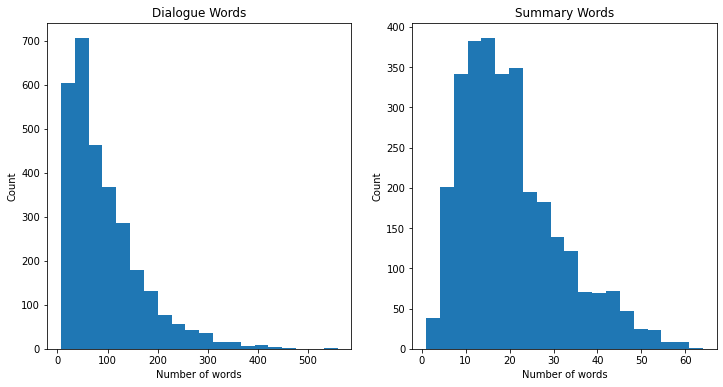

In [25]:
# Create pandas dataframe with dialogue and summary columns
# to facilate the calculation of the number of columns in each row
df = pd.DataFrame()
df["dialogue"] = samsum_dataset['train']["dialogue"]
df["dialogue_word_count"] = df['dialogue'].str.split().str.len()

df["summary"] = samsum_dataset['train']["summary"]
df["summary_word_count"] = df['summary'].str.split().str.len()

# plot both dialogue and summary distributions
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1 = axs[0]
ax2 = axs[1]

ax1.hist(df["dialogue_word_count"], bins=20)
ax1.set_title("Dialogue Words")
ax1.set_xlabel("Number of words")
ax1.set_ylabel("Count")

ax2.hist(df["summary_word_count"], bins=20)
ax2.set_title("Summary Words")
ax2.set_xlabel("Number of words")
ax2.set_ylabel("Count")

plt.show()

We see that there is just a few examples where the summaries are short sentences. This is good news, since summarization tasks rely on the quality of the summaries. If the summary is too short it can bias the model to only output a couple of words as summary.

Let's see the top 5 examples with less words in the summary

In [26]:
df.sort_values("summary_word_count").head(5)

,dialogue,dialogue_word_count,summary,summary_word_count
1760,Rivka: How do you like your neighborhood\r\nCo...,65,test,1
92,Joshua: look out the window\r\nNoah: what's th...,50,It's snowing outside.,3
1936,Gabi: I saw on FB that you got accepted \r\nGa...,22,Anne got accepted.,3
1259,Sally: Thanks for coming.\r\nEdie: Thanks for ...,33,Edie visited Sally.,3
2814,Amanda: Did you know Kelly got married???\r\nJ...,115,Kelly got married.,3


It doesn't look that bad. Except for the first row that it summary doesn't make sense. Let't filter out this example from the training set.

In [27]:
samsum_dataset = samsum_dataset.filter(lambda x: len(x['summary'].split(" ")) >= 3)

Loading cached processed dataset at /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e/cache-ff579acfa98961fd.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e/cache-0dbfa7297632dcb4.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e/cache-6560edc4634d15e4.arrow


## Baseline: lead-3 baseline

Before finetunning large pre-trained language models let's train a simple baseline that provides as summaries the firt three sentences of a dialogue.

In [28]:
# puntation rules
nltk.download("punkt")

def lead_three_baseline(text):
    """
    recives a text (dialogue) and output the first three
    sentences as summary
    """
    return "\n".join(sent_tokenize(text)[:3])


def evaluate_baseline(dataset, metric):
    """
    given a dataset and a metric e.g. Rouge computes the performance
    of the lead three baseline model
    """
    summaries = [lead_three_baseline(text) for text in dataset["dialogue"]]
    return metric.compute(predictions=summaries, references=dataset["summary"])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now that we have a function that performs the baseline and another one that evaluates it. Let's see it's performance (Rouge Score) on the validation dataset.

In [31]:
# load the rouge metric using the huggingface load_metric function
rouge_score = load_metric("rouge")
scores = evaluate_baseline(samsum_dataset["validation"], rouge_score)

# iterate over all the rouge metrics and print the middle one
for score_key in scores.keys():
    print(f"\n{score_key}: {round(scores[score_key].mid.fmeasure, 4) * 100}")


rouge1: 30.48

rouge2: 9.89

rougeL: 23.77

rougeLsum: 27.560000000000002


We can see that our simple baseline actually does not perform that bad, considering that it is a simple model. A Rouge1 score of 0.30 is a good starting point.

Let's try to make it better with the help of pre-trained large language models.

## Fine-Tunning Pre-Trained Models

### Data Preprocessing

In this section we will tokenize and encode the dialogues and their summaries using a tokenizer from a pre-trained model. Every pre-trained model that we will use follows a similar pre-processing recipe.

* Load model's checkpoint
* Create the tokenizer from the pre-trained model
* Tokenize the dataset

The main difference is that for the google/t5 model we need to concatenate the inputs with the prefix "summarize" so it recognize that we want to perform a summarization task.

In [13]:
max_input_length = 200
max_target_length = 30

def preprocess(examples):
    "Function that tokenize the dialogues and summaries"
    # truncation is applied since the dialogue/summary 
    # could be grater that the model's context size
    model_inputs = tokenizer(
        examples["dialogue"], max_length=max_input_length, truncation=True
    )
    
    with tokenizer.as_target_tokenizer(): # tokenize the labels in parallel to the inputs
        labels = tokenizer(
            examples["summary"], max_length=max_target_length, truncation=True
        )
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs


def t5_preprocess(examples):
    prefix = "summarize: "

    inputs = [prefix + doc for doc in examples["dialogue"]]

    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():

        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

### Model Evaluation
As we did for the baseline model, we are gonna evaluate our pre-trained models using the Rouge Score.

In [14]:
def compute_metrics(eval_pred):
    """
    Decodes the generated text and labels (actual) summaries and then
    computes the Rouge score
    """
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

### Experiments (Models)

Let's define a function that initialize the trainer object given a model, batch size, number of epochs and learning rate.

This function is gonna allow us to initialize multiple models without replicating a lot of code.

In [15]:
def init_trainer(model, batch_size, epochs, lr):
  logging_steps = num_samples // batch_size
  model_name = model_checkpoint.split("/")[-1]

  args = Seq2SeqTrainingArguments(
      output_dir=f"{model_name}-finetuned-samsum-en",
      evaluation_strategy="epoch",
      learning_rate=lr,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      weight_decay=0.01,
      save_total_limit=1,
      num_train_epochs=epochs,
      predict_with_generate=True, # allows to compute ROUGE for each epoch
      logging_steps=logging_steps,
      push_to_hub=True,
  )

  # dynamically pad the inputs and the labels
  data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

  trainer = Seq2SeqTrainer(
      model,
      args,
      train_dataset=tokenized_dataset["train"],
      eval_dataset=tokenized_dataset["validation"],
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
  )

  return trainer

Before going all in to finetune our models, let's create a print_summary function to help us test the model. And observe the generated summaries.

In [16]:
def print_summary(idx):
    dialogue = samsum_dataset["test"][idx]["dialogue"]
    target_summary = samsum_dataset["test"][idx]["summary"]
    summary = summarizer(samsum_dataset["test"][idx]["dialogue"])[0]['summary_text']
    print(f"'>>> Dialogue: {dialogue}'")
    print(f"\n'>>> Target Summary: {target_summary}'")
    print(f"\n'>>> Generated Summary: {summary}'")

#### Experiment 1: Fine-tunning google/t5-small



In [ ]:
model_checkpoint = "t5-small"

# create tokenizer from model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# tokenize the whole dataset
tokenized_dataset = samsum_dataset.map(t5_preprocess, batched=True)
# initialized a seq2seq model from the model_checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [ ]:
# initialize the trainer
trainer = init_trainer(model=model, batch_size=10, epochs=10, lr=5.6e-5)

# train google/t5-small
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/content/t5-small-finetuned-samsum-en is already a clone of https://huggingface.co/santiviquez/t5-small-finetuned-samsum-en. Make sure you pull the latest changes with `repo.git_pull()`.
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or 

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.491200,1.904253,44.151700,20.018600,36.605300,40.516400
2,1.505500,1.891174,44.147300,20.445600,37.069000,40.671400
3,1.485200,1.898570,44.753600,20.864600,37.525000,41.218900
4,1.453900,1.913614,44.214400,20.344600,37.108800,40.758100
5,1.426200,1.921455,44.265600,20.604400,37.326700,40.946900
6,1.411800,1.924697,43.879300,20.466300,37.061400,40.606500
7,1.398700,1.925640,43.998100,20.270300,36.785600,40.635400
8,1.382200,1.931605,43.973200,20.455900,36.803900,40.578400
9,1.377300,1.931414,44.307500,20.543500,37.045700,40.832000
10,1.379500,1.933470,44.331300,20.710000,37.221000,40.960300


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 10
Saving model checkpoint to t5-small-finetuned-samsum-en/checkpoint-500
Configuration saved in t5-small-finetuned-samsum-en/checkpoint-500/config.json
Model weights saved in t5-small-finetuned-samsum-en/checkpoint-500/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-samsum-en/checkpoint-500/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-samsum-en/checkpoint-500/special_tokens_map.json
Copy vocab file to t5-small-finetuned-samsum-en/checkpoint-500/spiece.model
tokenizer config file saved in t5-small-finetuned-samsum-en/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-samsum-en

TrainOutput(global_step=3000, training_loss=1.4311521301269532, metrics={'train_runtime': 726.7018, 'train_samples_per_second': 41.269, 'train_steps_per_second': 4.128, 'total_flos': 1577778771394560.0, 'train_loss': 1.4311521301269532, 'epoch': 10.0})

In [ ]:
# Pushes model to the huggingface hub
trainer.push_to_hub(commit_message="Training complete", tags="summarization")
trainer.evaluate()

Saving model checkpoint to t5-small-finetuned-samsum-en
Configuration saved in t5-small-finetuned-samsum-en/config.json
Model weights saved in t5-small-finetuned-samsum-en/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-samsum-en/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-samsum-en/special_tokens_map.json
Copy vocab file to t5-small-finetuned-samsum-en/spiece.model
Several commits (3) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/231M [00:00<?, ?B/s]

Upload file runs/Jun08_21-07-20_5c81e62530fa/events.out.tfevents.1654722445.5c81e62530fa.72.4:  31%|###       …

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/santiviquez/t5-small-finetuned-samsum-en
   b7b782c..4902510  main -> main

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/santiviquez/t5-small-finetuned-samsum-en
   4902510..902f4e6  main -> main

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 10


{'epoch': 10.0,
 'eval_loss': 1.9334697723388672,
 'eval_rouge1': 44.3313,
 'eval_rouge2': 20.71,
 'eval_rougeL': 37.221,
 'eval_rougeLsum': 40.9603,
 'eval_runtime': 21.0858,
 'eval_samples_per_second': 38.794,
 'eval_steps_per_second': 3.889}

Nice! Looking at the table above we got a Rouge1: 44.3 that means we beat the baseline!

Let's take a look at some of the genenerated summaries



In [ ]:
# huggingface hub model id
hub_model_id = "santiviquez/t5-small-finetuned-samsum-en"
# build a summarization pipeline from the model
summarizer = pipeline("summarization", model=hub_model_id)

In [ ]:
# Looking at some generated summaries.
print_summary(35)

Your max_length is set to 200, but you input_length is only 72. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


'>>> Dialogue: Janice: my son has been asking me to get him a hamster for his birthday
Janice: should i?
Martina: NO! NO! NO! NO! NO!
Martina: i got one for my son and it stank up the whole house
Martina: so don't do it!!!'

'>>> Target Summary: Martina advises against getting a hamster. '

'>>> Generated Summary: Janice's son has been asking Martina to get a hamster for his birthday. Martina got one for her son.'


The generated summary is not that bad. It made a mistake saying that Janince's has been asking **Martina** to get a hamster. Where actually Jannice's son has been asking **her**.


Let's try how does microsoft/ssr-base performs.

#### Experiment 2: Fine-tunning microsoft/ssr-base



In [16]:
model_checkpoint = "microsoft/ssr-base"

# create tokenizer from model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenized_dataset = samsum_dataset.map(preprocess, batched=True)
# initialized a seq2seq model from the model_checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)



Downloading:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/682 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [17]:
# initialize the trainer
trainer = init_trainer(model=model, batch_size=10, epochs=10, lr=5.6e-5)

# train microsoft/ssr-base
trainer.train()

Cloning https://huggingface.co/santiviquez/ssr-base-finetuned-samsum-en into local empty directory.
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2999
  Num Epochs = 10
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 3000
Automatic Weights & Biases logging enabled, to disable s

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.968200,1.643154,44.218200,20.848600,35.091400,40.985200
2,1.647500,1.594639,45.391900,21.695500,36.241100,41.853200
3,1.512100,1.573737,46.176900,22.417800,36.976200,42.661400
4,1.411200,1.577410,46.604700,22.822700,37.245700,43.193500
5,1.323000,1.582493,46.616200,22.485000,37.284600,42.983400
6,1.261300,1.588293,46.425300,22.119900,37.049100,42.518900
7,1.207700,1.596467,46.485000,22.363600,37.267700,42.749900
8,1.169700,1.617419,46.865400,22.629100,37.420100,43.087500
9,1.136700,1.618800,46.707000,22.305000,37.156000,42.908700
10,1.118000,1.623052,46.750500,22.396800,37.178400,42.891000


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 10
Saving model checkpoint to ssr-base-finetuned-samsum-en/checkpoint-500
Configuration saved in ssr-base-finetuned-samsum-en/checkpoint-500/config.json
Model weights saved in ssr-base-finetuned-samsum-en/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ssr-base-finetuned-samsum-en/checkpoint-500/tokenizer_config.json
Special tokens file saved in ssr-base-finetuned-samsum-en/checkpoint-500/special_tokens_map.json
Copy vocab file to ssr-base-finetuned-samsum-en/checkpoint-500/spiece.model
tokenizer config file saved in ssr-base-finetuned-samsum-en/tokenizer_config.json
Special tokens file saved in ssr-base-finetuned-samsum-en

TrainOutput(global_step=3000, training_loss=1.3755511067708333, metrics={'train_runtime': 2951.5358, 'train_samples_per_second': 10.161, 'train_steps_per_second': 1.016, 'total_flos': 7096060225382400.0, 'train_loss': 1.3755511067708333, 'epoch': 10.0})

In [18]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

trainer.evaluate()

Saving model checkpoint to ssr-base-finetuned-samsum-en
Configuration saved in ssr-base-finetuned-samsum-en/config.json
Model weights saved in ssr-base-finetuned-samsum-en/pytorch_model.bin
tokenizer config file saved in ssr-base-finetuned-samsum-en/tokenizer_config.json
Special tokens file saved in ssr-base-finetuned-samsum-en/special_tokens_map.json
Copy vocab file to ssr-base-finetuned-samsum-en/spiece.model
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/850M [00:00<?, ?B/s]

Upload file runs/Jun09_07-43-37_88d20da18147/events.out.tfevents.1654760639.88d20da18147.71.0:  32%|###2      …

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/santiviquez/ssr-base-finetuned-samsum-en
   7cc0473..26fb891  main -> main

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/santiviquez/ssr-base-finetuned-samsum-en
   26fb891..daddfeb  main -> main

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, dialogue, summary. If id, dialogue, summary are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 10


{'epoch': 10.0,
 'eval_loss': 1.6230522394180298,
 'eval_rouge1': 46.7505,
 'eval_rouge2': 22.3968,
 'eval_rougeL': 37.1784,
 'eval_rougeLsum': 42.891,
 'eval_runtime': 119.9558,
 'eval_samples_per_second': 6.819,
 'eval_steps_per_second': 0.684}

Wow a Rouge1 of 46.75, even better than what we got with google/t5-small.

In [17]:
# huggingface hub model id
hub_model_id = "santiviquez/ssr-base-finetuned-samsum-en"
# build a summarization pipeline from the model
summarizer = pipeline("summarization", model=hub_model_id)

Downloading:   0%|          | 0.00/850 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [18]:
# Looking at some generated summaries.
print_summary(35)

Your max_length is set to 200, but you input_length is only 70. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


'>>> Dialogue: Janice: my son has been asking me to get him a hamster for his birthday
Janice: should i?
Martina: NO! NO! NO! NO! NO!
Martina: i got one for my son and it stank up the whole house
Martina: so don't do it!!!'

'>>> Target Summary: Martina advises against getting a hamster. '

'>>> Generated Summary: Janice wants to buy her son a hamster for his birthday. Martina got one for her son and it stank up the whole house'


Although the general performace of ssr-base was better than t5-small we see that at least in this particular example the t5-small got a better result than the ssr-base.

#### Experiment 3: Fine-tunning facebook/bart-base

In [ ]:
model_checkpoint = "facebook/bart-base"

# create tokenizer from model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# tokenize the whole dataset
tokenized_dataset = samsum_dataset.map(preprocess, batched=True)
# initialized a seq2seq model from the model_checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
# initialize the trainer
trainer = init_trainer(model=model, batch_size=10, epochs=3, lr=5.6e-5)

# train facebook/bart-base
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/content/bart-base-finetuned-samsum-en is already a clone of https://huggingface.co/santiviquez/bart-base-finetuned-samsum-en. Make sure you pull the latest changes with `repo.git_pull()`.
The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: dialogue, id, summary. If dialogue, id, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instea

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.517200,2.161281,47.415200,22.810600,39.930000,43.363900
2,0.362700,2.277079,47.267600,22.632500,40.134500,43.190000
3,0.246600,2.367600,46.882500,22.092300,39.724900,42.918700


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: dialogue, id, summary. If dialogue, id, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 10
Saving model checkpoint to bart-base-finetuned-samsum-en/checkpoint-500
Configuration saved in bart-base-finetuned-samsum-en/checkpoint-500/config.json
Model weights saved in bart-base-finetuned-samsum-en/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-samsum-en/checkpoint-500/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-samsum-en/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bart-base-finetuned-samsum-en/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-samsum-en/special_tokens_map.json
Several commits (2) will be pushed upstr

TrainOutput(global_step=900, training_loss=0.3755176544189453, metrics={'train_runtime': 477.5472, 'train_samples_per_second': 18.84, 'train_steps_per_second': 1.885, 'total_flos': 1068193966694400.0, 'train_loss': 0.3755176544189453, 'epoch': 3.0})

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

trainer.evaluate()

Saving model checkpoint to bart-base-finetuned-samsum-en
Configuration saved in bart-base-finetuned-samsum-en/config.json
Model weights saved in bart-base-finetuned-samsum-en/pytorch_model.bin
tokenizer config file saved in bart-base-finetuned-samsum-en/tokenizer_config.json
Special tokens file saved in bart-base-finetuned-samsum-en/special_tokens_map.json
Several commits (3) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/532M [00:00<?, ?B/s]

Upload file runs/Jun08_22-12-39_f9a83209c253/events.out.tfevents.1654726364.f9a83209c253.73.2:  49%|####8     …

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/santiviquez/bart-base-finetuned-samsum-en
   690fbc7..666bd1f  main -> main

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/santiviquez/bart-base-finetuned-samsum-en
   666bd1f..3efb79a  main -> main

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: dialogue, id, summary. If dialogue, id, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 10


{'epoch': 3.0,
 'eval_loss': 2.3675997257232666,
 'eval_rouge1': 46.8825,
 'eval_rouge2': 22.0923,
 'eval_rougeL': 39.7249,
 'eval_rougeLsum': 42.9187,
 'eval_runtime': 44.7485,
 'eval_samples_per_second': 18.28,
 'eval_steps_per_second': 1.832}

Another improvement! We got an Rouge1 of 46.88. Bart-base slightly outperform ssr-base.

Looking at some genenerated summaries:

In [ ]:
hub_model_id = "santiviquez/bart-base-finetuned-samsum-en"
summarizer = pipeline("summarization", model=hub_model_id)

In [20]:
# Looking at some generated summaries.
print_summary(35)

Your max_length is set to 128, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


'>>> Dialogue: Janice: my son has been asking me to get him a hamster for his birthday
Janice: should i?
Martina: NO! NO! NO! NO! NO!
Martina: i got one for my son and it stank up the whole house
Martina: so don't do it!!!'

'>>> Target Summary: Martina advises against getting a hamster. '

'>>> Generated Summary: Janice's son wants Martina to buy him a hamster for his birthday. Martina refuses, because she got one for her son'


The generated summary made a similar mistake as the t5-small did. It said that Janince's has been asking **Martina** to get a hamster. Where actually Jannice's son has been asking **her**.


## Results

Final results drawn from the validation set

| Model              | Rouge1 | Rouge2 | RougeL | RougeLSum |
|--------------------|--------|--------|--------|-----------|
| baseline lead-3    | 30.48  | 9.89   | 23.77  | 27.56     |
| google/t5-small    | 44.33  | 20.71  | 37.22  | 40.96     |
| microsoft/ssr-base | 46.75  | 22.40  | 37.18  | 42.90     |
| facebook/bart      | 46.88  | 22.09  | 39.72  | 42.92     |

From the above table we see that all of our models permormed better that the lead-3 baseline which is a good news. Since we would expect pre-trained large language models perfoms better that a simple heuristic.

microsoft/ssr-base and facebook/bart gave very similar results. facebook/bart performs slighly better in most of the Rouge metrics.

Overall the results are good. Evaluating this kind of task is always hard. Sometimes automatic evaluations does not fully represent the performance of the model.


If you want to test the model with your own dialogues we deployed the facebook/bart final model [here]("https://share.streamlit.io/santiviquez/conversation-summarization/main/app.py).


<center>
Fin.
</center>